
Grammatical Evolution for Medical Diagnosis
Demonstrating Core GE Concepts

[Step 1] Data Generation
Generating Synthetic Patient Data

Generated 200 patients

Feature Summary:
  AGE range: 26 - 85
  SMOKING distribution: {0: np.int64(106), 1: np.int64(42), 2: np.int64(52)}
  CHEST_PAIN: 67 positive (33.5%)
  COUGHING: 73 positive (36.5%)
  FATIGUE: 99 positive (49.5%)

Target Distribution:
  Low Risk (0): 108 (54.0%)
  High Risk (1): 92 (46.0%)

[Step 2] Grammar Definition

BNF Grammar for Medical Diagnosis

Terminals: 0, 1, 2, 40, 50, 60, 70, ==, >, AGE, CHEST_PAIN, COUGHING, FATIGUE, SMOKING, and, or
Non-terminals: <age-threshold>, <feature>, <rule>, <simple-check>, <smoking-value>

Production Rules:
  <rule> ::= <simple-check> | <simple-check> and <simple-check> | <simple-check> or <simple-check>
  <simple-check> ::= <feature> == 1 | <feature> == 0 | AGE > <age-threshold> | SMOKING == <smoking-value>
  <feature> ::= CHEST_PAIN | COUGHING | FATIGUE
  <age-threshold> ::= 40 | 50 | 6

C:\Users\awwal\AppData\Local\Temp\ipykernel_41620\1652803123.py:591: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Evolution plot saved to: ./ge_evolution_process.png


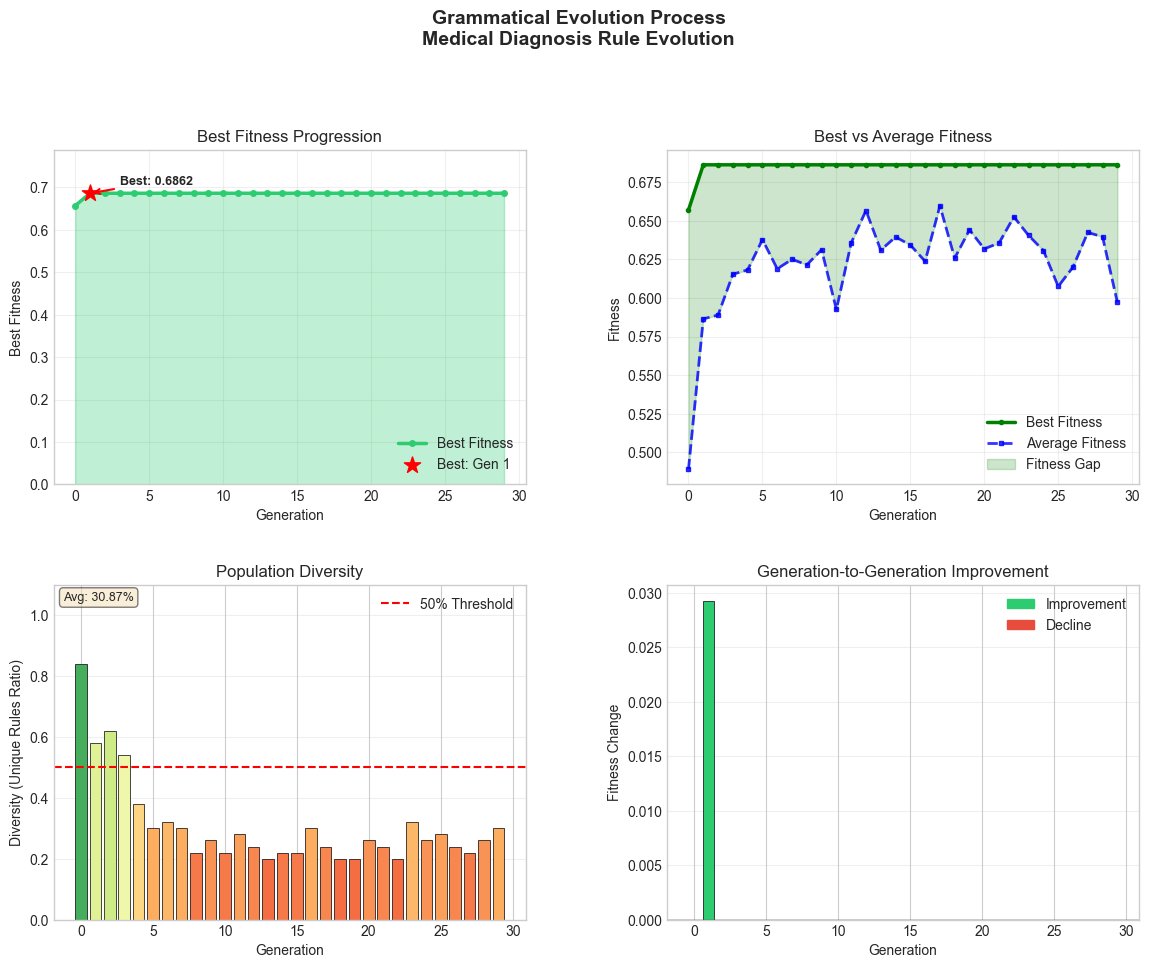


2. Rule performance...
Performance plot saved to: ./ge_rule_performance.png


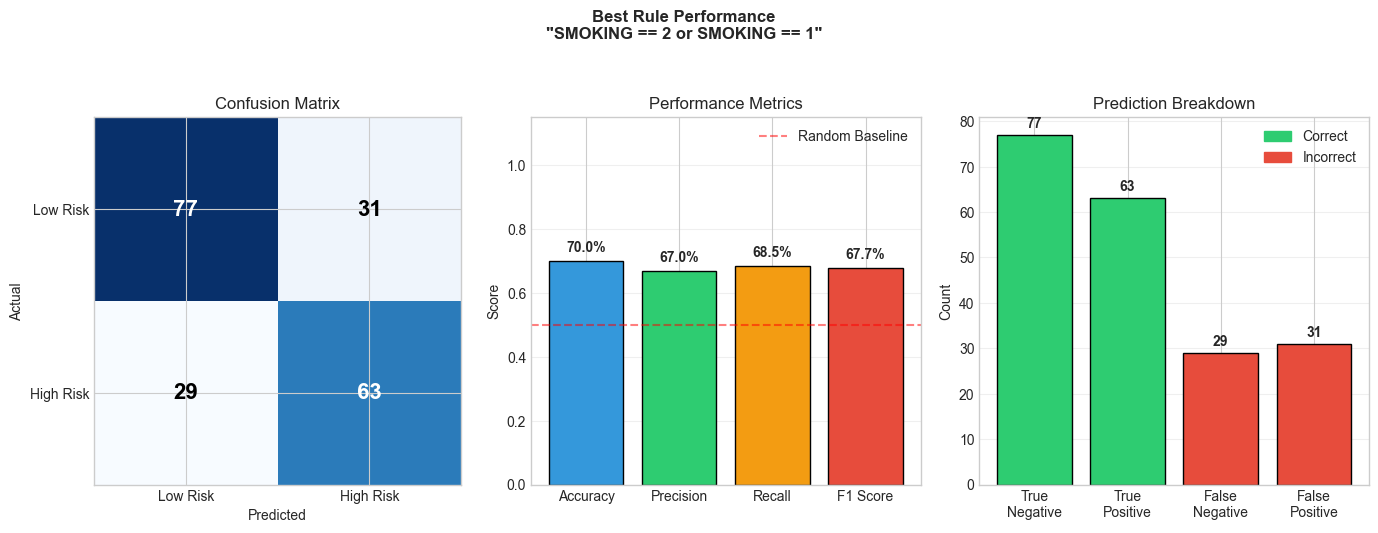


3. Grammar structure...
Grammar plot saved to: ./ge_grammar_structure.png


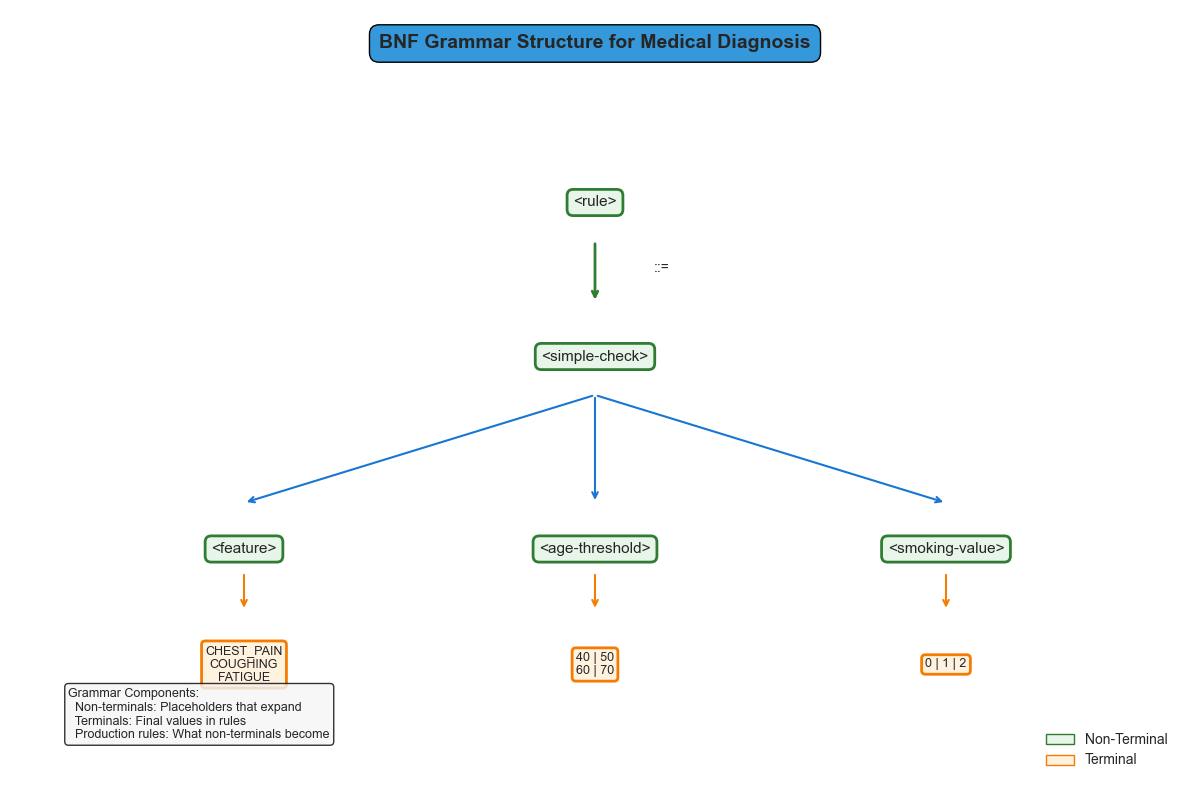


All plots saved to: ./

Key GE Concepts Demonstrated:

    1. Grammar (BNFGrammar):
       - Terminals: SMOKING, CHEST_PAIN, ==, 1, 0, 40, etc.
       - Non-terminals: <rule>, <simple-check>, <feature>, etc.
       - Production rules: What each non-terminal can become
       - Start symbol: <rule>

    2. Chromosome (List of integers):
       - Example: [5, 12, 3, 7, 0, 1]
       - Each integer (codon) controls one grammar choice

    3. Genotype to Phenotype Mapping (GEMapper):
       - Uses modulo to select production rules
       - Example: codon=5, options=3: 5 % 3 = 2 -> option[2]

    4. Fitness Evaluation:
       - Evaluates rule on patient data
       - Computes accuracy, precision, recall, F1

    5. Evolution (GrammaticalEvolution):
       - Tournament selection
       - Single-point crossover
       - Mutation
       - Elitism

    6. Interpretability:
       - Evolved rules are human-readable
       - Doctors can understand and validate them
    

Demonstration Complete


In [2]:
"""
Grammatical Evolution for Lung Cancer Risk Classification 
==========================================================
This implementation demonstrates core GE concepts:

1. BNF Grammar - Defines the structure of valid diagnosis rules
2. Genotype-to-Phenotype Mapping - Converts integer chromosomes to rules
3. Fitness Evaluation - Measures rule quality on patient data
4. Evolutionary Operators - Selection, crossover, mutation

"""

import numpy as np
import pandas as pd
import random
from typing import Dict, List, Tuple, Any
from dataclasses import dataclass
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


# -----------------------------------------------------------------------------
# Data Generation
# -----------------------------------------------------------------------------

def generate_synthetic_patient_data(n_samples: int = 200) -> pd.DataFrame:
    """
    Generate synthetic patient data for lung cancer risk prediction.
    
    Features:
        AGE: Patient age (25-85)
        SMOKING: 0=Never, 1=Former, 2=Current
        CHEST_PAIN: 0=No, 1=Yes
        COUGHING: 0=No, 1=Yes
        FATIGUE: 0=No, 1=Yes
    
    Target:
        RISK: 0=Low risk, 1=High risk
    """
    print("=" * 60)
    print("Generating Synthetic Patient Data")
    print("=" * 60)
    
    data = []
    
    for i in range(n_samples):
        age = np.random.randint(25, 86)
        smoking = np.random.choice([0, 1, 2], p=[0.5, 0.2, 0.3])
        chest_pain = np.random.choice([0, 1], p=[0.7, 0.3])
        coughing = np.random.choice([0, 1], p=[0.6, 0.4])
        fatigue = np.random.choice([0, 1], p=[0.5, 0.5])
        
        # Calculate risk score based on medical factors
        risk_score = 0
        
        if age > 60:
            risk_score += 2
        elif age > 50:
            risk_score += 1
        
        if smoking == 2:
            risk_score += 3
        elif smoking == 1:
            risk_score += 1
        
        if chest_pain == 1:
            risk_score += 2
        if coughing == 1:
            risk_score += 1
        if fatigue == 1:
            risk_score += 0.5
        
        if smoking >= 1 and (chest_pain == 1 or coughing == 1):
            risk_score += 1.5
        
        prob_high_risk = 1 / (1 + np.exp(-0.5 * (risk_score - 4)))
        risk = 1 if np.random.random() < prob_high_risk else 0
        
        data.append({
            'AGE': age,
            'SMOKING': smoking,
            'CHEST_PAIN': chest_pain,
            'COUGHING': coughing,
            'FATIGUE': fatigue,
            'RISK': risk
        })
    
    df = pd.DataFrame(data)
    
    print(f"\nGenerated {n_samples} patients")
    print(f"\nFeature Summary:")
    print(f"  AGE range: {df['AGE'].min()} - {df['AGE'].max()}")
    print(f"  SMOKING distribution: {dict(df['SMOKING'].value_counts().sort_index())}")
    print(f"  CHEST_PAIN: {df['CHEST_PAIN'].sum()} positive ({100*df['CHEST_PAIN'].mean():.1f}%)")
    print(f"  COUGHING: {df['COUGHING'].sum()} positive ({100*df['COUGHING'].mean():.1f}%)")
    print(f"  FATIGUE: {df['FATIGUE'].sum()} positive ({100*df['FATIGUE'].mean():.1f}%)")
    print(f"\nTarget Distribution:")
    print(f"  Low Risk (0): {(df['RISK'] == 0).sum()} ({100*(df['RISK'] == 0).mean():.1f}%)")
    print(f"  High Risk (1): {(df['RISK'] == 1).sum()} ({100*(df['RISK'] == 1).mean():.1f}%)")
    
    return df


# -----------------------------------------------------------------------------
# BNF Grammar Definition
# -----------------------------------------------------------------------------

class BNFGrammar:
    """
    Backus-Naur Form Grammar for Medical Diagnosis Rules.
    
    Grammar Structure:
        <rule> ::= <simple-check>
                 | <simple-check> AND <simple-check>
                 | <simple-check> OR <simple-check>
        
        <simple-check> ::= <feature> == 1
                         | <feature> == 0
                         | AGE > <age-threshold>
                         | SMOKING == <smoking-value>
        
        <feature> ::= CHEST_PAIN | COUGHING | FATIGUE
        <age-threshold> ::= 40 | 50 | 60 | 70
        <smoking-value> ::= 0 | 1 | 2
    """
    
    def __init__(self):
        self.rules = {
            'rule': [
                '<simple-check>',
                '<simple-check> and <simple-check>',
                '<simple-check> or <simple-check>',
            ],
            'simple-check': [
                '<feature> == 1',
                '<feature> == 0',
                'AGE > <age-threshold>',
                'SMOKING == <smoking-value>',
            ],
            'feature': ['CHEST_PAIN', 'COUGHING', 'FATIGUE'],
            'age-threshold': ['40', '50', '60', '70'],
            'smoking-value': ['0', '1', '2']
        }
        self.start_symbol = 'rule'
        self._print_grammar_info()
    
    def _print_grammar_info(self):
        print("\n" + "=" * 60)
        print("BNF Grammar for Medical Diagnosis")
        print("=" * 60)
        
        non_terminals = set(self.rules.keys())
        terminals = set()
        
        for productions in self.rules.values():
            for prod in productions:
                tokens = prod.replace('<', ' <').replace('>', '> ').split()
                for token in tokens:
                    if not token.startswith('<'):
                        terminals.add(token)
        
        print(f"\nTerminals: {', '.join(sorted(terminals))}")
        print(f"Non-terminals: {', '.join(['<' + nt + '>' for nt in sorted(non_terminals)])}")
        print(f"\nProduction Rules:")
        for nt, prods in self.rules.items():
            print(f"  <{nt}> ::= {' | '.join(prods)}")
        print(f"\nStart Symbol: <{self.start_symbol}>")
        
        total_space = 1
        for prods in self.rules.values():
            total_space *= len(prods)
        print(f"Search Space: ~{total_space:,} possible rules")
    
    def get_productions(self, non_terminal: str) -> List[str]:
        return self.rules.get(non_terminal.strip('<>'), [])
    
    def num_productions(self, non_terminal: str) -> int:
        return len(self.get_productions(non_terminal))


# -----------------------------------------------------------------------------
# Genotype-to-Phenotype Mapping
# -----------------------------------------------------------------------------

class GEMapper:
    """
    Maps integer chromosomes to rule strings using the BNF grammar.
    
    The mapping uses modulo arithmetic to select production rules:
        choice_index = codon % number_of_options
    """
    
    def __init__(self, grammar: BNFGrammar, max_wraps: int = 2):
        self.grammar = grammar
        self.max_wraps = max_wraps
    
    def map(self, chromosome: List[int], verbose: bool = False) -> Tuple[str, bool]:
        if verbose:
            print("\n" + "=" * 60)
            print("Genotype to Phenotype Mapping")
            print("=" * 60)
            print(f"\nChromosome: {chromosome}")
            print(f"Length: {len(chromosome)} codons")
        
        current = f'<{self.grammar.start_symbol}>'
        codon_index = 0
        wraps = 0
        step = 1
        
        if verbose:
            print(f"\nStarting with: {current}")
        
        while '<' in current:
            start_pos = current.find('<')
            end_pos = current.find('>', start_pos)
            non_terminal = current[start_pos+1:end_pos]
            
            productions = self.grammar.get_productions(non_terminal)
            n_options = len(productions)
            
            if n_options == 0:
                return current, False
            
            if codon_index >= len(chromosome):
                wraps += 1
                if wraps > self.max_wraps:
                    return current, False
                codon_index = 0
            
            codon = chromosome[codon_index]
            choice_index = codon % n_options
            chosen_production = productions[choice_index]
            
            if verbose:
                print(f"\nStep {step}:")
                print(f"  Non-terminal: <{non_terminal}>")
                print(f"  Codon: {codon}, Options: {n_options}")
                print(f"  Calculation: {codon} % {n_options} = {choice_index}")
                print(f"  Chosen: {chosen_production}")
            
            current = current[:start_pos] + chosen_production + current[end_pos+1:]
            
            if verbose:
                print(f"  Result: {current}")
            
            codon_index += 1
            step += 1
            
            if step > 100:
                return current, False
        
        if verbose:
            print(f"\nFinal Rule: {current}")
        
        return current, True


# -----------------------------------------------------------------------------
# Fitness Evaluation
# -----------------------------------------------------------------------------

def evaluate_rule(rule_string: str, data: pd.DataFrame) -> Dict[str, Any]:
    """Evaluate a rule on patient data and return performance metrics."""
    try:
        predictions = []
        
        for idx, row in data.iterrows():
            AGE = row['AGE']
            SMOKING = row['SMOKING']
            CHEST_PAIN = row['CHEST_PAIN']
            COUGHING = row['COUGHING']
            FATIGUE = row['FATIGUE']
            
            try:
                result = eval(rule_string)
                predictions.append(1 if result else 0)
            except:
                predictions.append(0)
        
        predictions = np.array(predictions)
        actuals = data['RISK'].values
        
        correct = (predictions == actuals).sum()
        accuracy = correct / len(actuals)
        
        tp = ((predictions == 1) & (actuals == 1)).sum()
        fp = ((predictions == 1) & (actuals == 0)).sum()
        fn = ((predictions == 0) & (actuals == 1)).sum()
        tn = ((predictions == 0) & (actuals == 0)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        rule_length = len(rule_string)
        interpretability = max(0, 1 - rule_length / 100)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'interpretability': interpretability,
            'predictions': predictions,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
        }
        
    except Exception as e:
        return {
            'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0,
            'interpretability': 0, 'predictions': np.zeros(len(data)),
            'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0, 'error': str(e)
        }


def fitness_function(rule_string: str, data: pd.DataFrame) -> float:
    """Compute weighted fitness: 0.7*F1 + 0.2*Accuracy + 0.1*Interpretability"""
    metrics = evaluate_rule(rule_string, data)
    return 0.7 * metrics['f1'] + 0.2 * metrics['accuracy'] + 0.1 * metrics['interpretability']


# -----------------------------------------------------------------------------
# Genetic Operators
# -----------------------------------------------------------------------------

def create_random_chromosome(length: int = 10, max_value: int = 255) -> List[int]:
    return [random.randint(0, max_value) for _ in range(length)]


def tournament_selection(population: List[List[int]], fitnesses: List[float],
                         tournament_size: int = 3) -> List[int]:
    indices = random.sample(range(len(population)), tournament_size)
    winner_idx = max(indices, key=lambda i: fitnesses[i])
    return copy.deepcopy(population[winner_idx])


def single_point_crossover(parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
    if len(parent1) != len(parent2):
        min_len = min(len(parent1), len(parent2))
        parent1 = parent1[:min_len]
        parent2 = parent2[:min_len]
    
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2


def mutation(chromosome: List[int], mutation_rate: float = 0.1,
             max_value: int = 255) -> List[int]:
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            mutated[i] = random.randint(0, max_value)
    return mutated


# -----------------------------------------------------------------------------
# Individual and GE Engine
# -----------------------------------------------------------------------------

@dataclass
class Individual:
    chromosome: List[int]
    rule: str = ""
    fitness: float = 0.0
    valid: bool = False


class GrammaticalEvolution:
    """
    Grammatical Evolution engine for evolving medical diagnosis rules.
    """
    
    def __init__(self, grammar: BNFGrammar, data: pd.DataFrame,
                 population_size: int = 50, generations: int = 30,
                 chromosome_length: int = 15, crossover_rate: float = 0.8,
                 mutation_rate: float = 0.1, tournament_size: int = 3,
                 elitism: int = 2, verbose: bool = True):
        
        self.grammar = grammar
        self.mapper = GEMapper(grammar)
        self.data = data
        self.population_size = population_size
        self.generations = generations
        self.chromosome_length = chromosome_length
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.elitism = elitism
        self.verbose = verbose
        
        self.history = {
            'best_fitness': [],
            'avg_fitness': [],
            'best_rule': [],
            'diversity': []
        }
    
    def _create_individual(self, chromosome: List[int]) -> Individual:
        ind = Individual(chromosome=chromosome)
        rule, valid = self.mapper.map(chromosome, verbose=False)
        ind.rule = rule
        ind.valid = valid
        ind.fitness = fitness_function(rule, self.data) if valid else 0.0
        return ind
    
    def _initialize_population(self) -> List[Individual]:
        return [self._create_individual(create_random_chromosome(self.chromosome_length))
                for _ in range(self.population_size)]
    
    def _compute_diversity(self, population: List[Individual]) -> float:
        unique_rules = set(ind.rule for ind in population)
        return len(unique_rules) / len(population)
    
    def evolve(self) -> Individual:
        print("\n" + "=" * 60)
        print("Grammatical Evolution - Evolving Diagnosis Rules")
        print("=" * 60)
        print(f"\nParameters:")
        print(f"  Population Size: {self.population_size}")
        print(f"  Generations: {self.generations}")
        print(f"  Chromosome Length: {self.chromosome_length}")
        print(f"  Crossover Rate: {self.crossover_rate}")
        print(f"  Mutation Rate: {self.mutation_rate}")
        
        print(f"\nInitializing population...")
        population = self._initialize_population()
        best_ever = max(population, key=lambda ind: ind.fitness)
        
        print(f"\n{'-'*60}")
        print(f"{'Gen':>4} | {'Best':>8} | {'Avg':>8} | {'Diversity':>9} | Best Rule")
        print(f"{'-'*60}")
        
        for gen in range(self.generations):
            population.sort(key=lambda ind: ind.fitness, reverse=True)
            
            fitnesses = [ind.fitness for ind in population]
            best_fitness = max(fitnesses)
            avg_fitness = np.mean(fitnesses)
            diversity = self._compute_diversity(population)
            
            self.history['best_fitness'].append(best_fitness)
            self.history['avg_fitness'].append(avg_fitness)
            self.history['best_rule'].append(population[0].rule)
            self.history['diversity'].append(diversity)
            
            if population[0].fitness > best_ever.fitness:
                best_ever = copy.deepcopy(population[0])
            
            if gen % 5 == 0 or gen == self.generations - 1:
                rule_preview = population[0].rule[:40] + "..." if len(population[0].rule) > 40 else population[0].rule
                print(f"{gen:4d} | {best_fitness:8.4f} | {avg_fitness:8.4f} | {diversity:9.2f} | {rule_preview}")
            
            new_population = [copy.deepcopy(population[i]) for i in range(self.elitism)]
            
            while len(new_population) < self.population_size:
                parent1 = tournament_selection(
                    [ind.chromosome for ind in population],
                    [ind.fitness for ind in population],
                    self.tournament_size
                )
                parent2 = tournament_selection(
                    [ind.chromosome for ind in population],
                    [ind.fitness for ind in population],
                    self.tournament_size
                )
                
                if random.random() < self.crossover_rate:
                    child1_chrom, child2_chrom = single_point_crossover(parent1, parent2)
                else:
                    child1_chrom, child2_chrom = parent1.copy(), parent2.copy()
                
                child1_chrom = mutation(child1_chrom, self.mutation_rate)
                child2_chrom = mutation(child2_chrom, self.mutation_rate)
                
                new_population.append(self._create_individual(child1_chrom))
                if len(new_population) < self.population_size:
                    new_population.append(self._create_individual(child2_chrom))
            
            population = new_population
        
        print(f"{'-'*60}")
        return best_ever


# -----------------------------------------------------------------------------
# Visualization Functions
# -----------------------------------------------------------------------------

def plot_evolution_process(ge: GrammaticalEvolution, save_path: str = None):
    """Plot the evolutionary process showing fitness and diversity trends."""
    fig = plt.figure(figsize=(14, 10))
    fig.suptitle('Grammatical Evolution Process\nMedical Diagnosis Rule Evolution',
                 fontsize=14, fontweight='bold', y=1.02)
    
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    generations = range(len(ge.history['best_fitness']))
    best_fitness = ge.history['best_fitness']
    avg_fitness = ge.history['avg_fitness']
    diversity = ge.history['diversity']
    
    # Plot 1: Best Fitness
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(generations, best_fitness, '-', linewidth=2.5, marker='o',
             markersize=4, label='Best Fitness', color='#2ecc71')
    ax1.fill_between(generations, 0, best_fitness, alpha=0.3, color='#2ecc71')
    
    best_gen = np.argmax(best_fitness)
    ax1.scatter([best_gen], [best_fitness[best_gen]], s=150, c='red',
                marker='*', zorder=5, label=f'Best: Gen {best_gen}')
    ax1.annotate(f'Best: {best_fitness[best_gen]:.4f}',
                 xy=(best_gen, best_fitness[best_gen]),
                 xytext=(best_gen + 2, best_fitness[best_gen] + 0.02),
                 fontsize=9, fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Fitness')
    ax1.set_title('Best Fitness Progression')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, max(best_fitness) * 1.15)
    
    # Plot 2: Best vs Average
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(generations, best_fitness, 'g-', linewidth=2.5,
             label='Best Fitness', marker='o', markersize=3)
    ax2.plot(generations, avg_fitness, 'b--', linewidth=2,
             label='Average Fitness', marker='s', markersize=3, alpha=0.8)
    ax2.fill_between(generations, avg_fitness, best_fitness,
                     alpha=0.2, color='green', label='Fitness Gap')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Fitness')
    ax2.set_title('Best vs Average Fitness')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Diversity
    ax3 = fig.add_subplot(gs[1, 0])
    colors = plt.cm.RdYlGn(np.array(diversity))
    ax3.bar(generations, diversity, color=colors, edgecolor='black', linewidth=0.5)
    ax3.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5,
                label='50% Threshold')
    
    ax3.set_xlabel('Generation')
    ax3.set_ylabel('Diversity (Unique Rules Ratio)')
    ax3.set_title('Population Diversity')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, 1.1)
    
    avg_diversity = np.mean(diversity)
    ax3.text(0.02, 0.98, f'Avg: {avg_diversity:.2%}',
             transform=ax3.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 4: Improvement
    ax4 = fig.add_subplot(gs[1, 1])
    improvements = [0] + [best_fitness[i] - best_fitness[i-1]
                         for i in range(1, len(best_fitness))]
    colors = ['#2ecc71' if imp >= 0 else '#e74c3c' for imp in improvements]
    ax4.bar(generations, improvements, color=colors, edgecolor='black', linewidth=0.5)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    ax4.set_xlabel('Generation')
    ax4.set_ylabel('Fitness Change')
    ax4.set_title('Generation-to-Generation Improvement')
    ax4.grid(True, alpha=0.3, axis='y')
    
    green_patch = mpatches.Patch(color='#2ecc71', label='Improvement')
    red_patch = mpatches.Patch(color='#e74c3c', label='Decline')
    ax4.legend(handles=[green_patch, red_patch], loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        print(f"\nEvolution plot saved to: {save_path}")
    
    plt.show()
    return fig


def plot_rule_performance(best_individual: Individual, data: pd.DataFrame,
                          save_path: str = None):
    """Plot performance metrics of the best evolved rule."""
    metrics = evaluate_rule(best_individual.rule, data)
    
    fig = plt.figure(figsize=(14, 5))
    fig.suptitle(f'Best Rule Performance\n"{best_individual.rule}"',
                 fontsize=12, fontweight='bold', y=1.05)
    
    # Confusion Matrix
    ax1 = fig.add_subplot(131)
    cm = np.array([[metrics['tn'], metrics['fp']],
                   [metrics['fn'], metrics['tp']]])
    im = ax1.imshow(cm, cmap='Blues')
    
    for i in range(2):
        for j in range(2):
            color = 'white' if cm[i, j] > cm.max()/2 else 'black'
            ax1.text(j, i, f'{cm[i, j]}', ha='center', va='center',
                    fontsize=16, fontweight='bold', color=color)
    
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    ax1.set_xticklabels(['Low Risk', 'High Risk'])
    ax1.set_yticklabels(['Low Risk', 'High Risk'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix')
    
    # Metrics Bar Chart
    ax2 = fig.add_subplot(132)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_values = [metrics['accuracy'], metrics['precision'],
                     metrics['recall'], metrics['f1']]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    
    bars = ax2.bar(metric_names, metric_values, color=colors, edgecolor='black', linewidth=1)
    
    for bar, val in zip(bars, metric_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2.set_ylim(0, 1.15)
    ax2.set_ylabel('Score')
    ax2.set_title('Performance Metrics')
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Prediction Breakdown
    ax3 = fig.add_subplot(133)
    predictions = metrics['predictions']
    actuals = data['RISK'].values
    
    correct_low = ((predictions == 0) & (actuals == 0)).sum()
    correct_high = ((predictions == 1) & (actuals == 1)).sum()
    incorrect_low = ((predictions == 0) & (actuals == 1)).sum()
    incorrect_high = ((predictions == 1) & (actuals == 0)).sum()
    
    categories = ['True\nNegative', 'True\nPositive', 'False\nNegative', 'False\nPositive']
    values = [correct_low, correct_high, incorrect_low, incorrect_high]
    colors = ['#2ecc71', '#2ecc71', '#e74c3c', '#e74c3c']
    
    bars = ax3.bar(categories, values, color=colors, edgecolor='black', linewidth=1)
    
    for bar, val in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax3.set_ylabel('Count')
    ax3.set_title('Prediction Breakdown')
    ax3.grid(True, alpha=0.3, axis='y')
    
    green_patch = mpatches.Patch(color='#2ecc71', label='Correct')
    red_patch = mpatches.Patch(color='#e74c3c', label='Incorrect')
    ax3.legend(handles=[green_patch, red_patch], loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        print(f"Performance plot saved to: {save_path}")
    
    plt.show()
    return fig


def plot_grammar_structure(grammar: BNFGrammar, save_path: str = None):
    """Create a visual representation of the grammar structure."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    ax.text(5, 9.5, 'BNF Grammar Structure for Medical Diagnosis',
            fontsize=14, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#3498db', edgecolor='black'))
    
    non_terminals = {
        'rule': (5, 7.5),
        'simple-check': (5, 5.5),
        'feature': (2, 3),
        'age-threshold': (5, 3),
        'smoking-value': (8, 3)
    }
    
    for nt, (x, y) in non_terminals.items():
        bbox = dict(boxstyle='round,pad=0.4', facecolor='#e8f5e9', edgecolor='#2e7d32', linewidth=2)
        ax.text(x, y, f'<{nt}>', fontsize=11, ha='center', va='center', bbox=bbox)
    
    ax.annotate('', xy=(5, 6.2), xytext=(5, 7.0),
                arrowprops=dict(arrowstyle='->', color='#2e7d32', lw=2))
    ax.text(5.5, 6.6, '::=', fontsize=10, ha='left')
    
    for target_x in [2, 5, 8]:
        ax.annotate('', xy=(target_x, 3.6), xytext=(5, 5.0),
                    arrowprops=dict(arrowstyle='->', color='#1976d2', lw=1.5))
    
    terminals = {
        'CHEST_PAIN\nCOUGHING\nFATIGUE': (2, 1.5),
        '40 | 50\n60 | 70': (5, 1.5),
        '0 | 1 | 2': (8, 1.5)
    }
    
    for term, (x, y) in terminals.items():
        bbox = dict(boxstyle='round,pad=0.3', facecolor='#fff3e0', edgecolor='#f57c00', linewidth=2)
        ax.text(x, y, term, fontsize=9, ha='center', va='center', bbox=bbox)
    
    ax.annotate('', xy=(2, 2.2), xytext=(2, 2.7),
                arrowprops=dict(arrowstyle='->', color='#f57c00', lw=1.5))
    ax.annotate('', xy=(5, 2.2), xytext=(5, 2.7),
                arrowprops=dict(arrowstyle='->', color='#f57c00', lw=1.5))
    ax.annotate('', xy=(8, 2.2), xytext=(8, 2.7),
                arrowprops=dict(arrowstyle='->', color='#f57c00', lw=1.5))
    
    legend_elements = [
        mpatches.Patch(facecolor='#e8f5e9', edgecolor='#2e7d32', label='Non-Terminal'),
        mpatches.Patch(facecolor='#fff3e0', edgecolor='#f57c00', label='Terminal'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    explanation = (
        "Grammar Components:\n"
        "  Non-terminals: Placeholders that expand\n"
        "  Terminals: Final values in rules\n"
        "  Production rules: What non-terminals become"
    )
    ax.text(0.5, 0.5, explanation, fontsize=9, va='bottom',
            bbox=dict(boxstyle='round', facecolor='#f5f5f5', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        print(f"Grammar plot saved to: {save_path}")
    
    plt.show()
    return fig


# -----------------------------------------------------------------------------
# Display Results
# -----------------------------------------------------------------------------

def display_results(best_individual: Individual, data: pd.DataFrame,
                    ge: GrammaticalEvolution):
    """Display comprehensive results of the evolution."""
    print("\n" + "=" * 60)
    print("Evolution Results")
    print("=" * 60)
    
    print(f"\nBest Evolved Rule:")
    print(f"  {best_individual.rule}")
    
    print(f"\nChromosome (Genotype):")
    print(f"  {best_individual.chromosome}")
    
    metrics = evaluate_rule(best_individual.rule, data)
    
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:    {metrics['accuracy']:.2%}")
    print(f"  Precision:   {metrics['precision']:.2%}")
    print(f"  Recall:      {metrics['recall']:.2%}")
    print(f"  F1 Score:    {metrics['f1']:.2%}")
    print(f"  Fitness:     {best_individual.fitness:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(f"                  Predicted")
    print(f"                Low    High")
    print(f"  Actual Low   {metrics['tn']:4d}   {metrics['fp']:4d}")
    print(f"  Actual High  {metrics['fn']:4d}   {metrics['tp']:4d}")
    
    print(f"\nRule Interpretation:")
    print(f"  Predicts HIGH RISK when:")
    
    rule = best_individual.rule
    if 'and' in rule.lower():
        conditions = rule.split(' and ')
        print(f"  ALL of these are true:")
        for cond in conditions:
            print(f"    - {cond.strip()}")
    elif 'or' in rule.lower():
        conditions = rule.split(' or ')
        print(f"  ANY of these are true:")
        for cond in conditions:
            print(f"    - {cond.strip()}")
    else:
        print(f"    - {rule}")
    
    print(f"\nEvolution Summary:")
    print(f"  Starting Fitness: {ge.history['best_fitness'][0]:.4f}")
    print(f"  Final Fitness:    {ge.history['best_fitness'][-1]:.4f}")
    print(f"  Improvement:      {ge.history['best_fitness'][-1] - ge.history['best_fitness'][0]:.4f}")
    print(f"  Generations:      {len(ge.history['best_fitness'])}")


def demonstrate_mapping():
    """Demonstrate the chromosome to rule mapping process."""
    print("\n" + "=" * 60)
    print("Demonstration: Chromosome to Rule Mapping")
    print("=" * 60)
    print("\nThis shows how GE converts integers to rules.")
    
    grammar = BNFGrammar()
    mapper = GEMapper(grammar)
    
    examples = [
        ([0, 0, 0, 0], "Single simple check"),
        ([1, 0, 1, 2, 0], "Two checks with AND"),
        ([2, 1, 0, 3, 1], "Two checks with OR"),
        ([0, 2, 3], "Age-based rule"),
    ]
    
    for chromosome, description in examples:
        print(f"\n{'-'*60}")
        print(f"Example: {description}")
        print(f"{'-'*60}")
        rule, valid = mapper.map(chromosome, verbose=True)


def plot_all_results(best_individual: Individual, data: pd.DataFrame,
                     ge: GrammaticalEvolution, output_dir: str = '.'):
    """Generate and save all visualization plots."""
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n" + "=" * 60)
    print("Generating Visualization Plots")
    print("=" * 60)
    
    print("\n1. Evolution process...")
    plot_evolution_process(ge, save_path=f"{output_dir}/ge_evolution_process.png")
    
    print("\n2. Rule performance...")
    plot_rule_performance(best_individual, data,
                         save_path=f"{output_dir}/ge_rule_performance.png")
    
    print("\n3. Grammar structure...")
    plot_grammar_structure(ge.grammar,
                          save_path=f"{output_dir}/ge_grammar_structure.png")
    
    print("\n" + "=" * 60)
    print(f"All plots saved to: {output_dir}/")
    print("=" * 60)


# -----------------------------------------------------------------------------
# Main Execution
# -----------------------------------------------------------------------------

def main():
    """Run the complete GE medical diagnosis demonstration."""
    
    print("\n" + "=" * 60)
    print("Grammatical Evolution for Medical Diagnosis")
    print("Demonstrating Core GE Concepts")
    print("=" * 60)
    
    # Step 1: Generate data
    print("\n[Step 1] Data Generation")
    data = generate_synthetic_patient_data(n_samples=200)
    
    # Step 2: Define grammar
    print("\n[Step 2] Grammar Definition")
    grammar = BNFGrammar()
    
    # Step 3: Demonstrate mapping
    print("\n[Step 3] Mapping Demonstration")
    demonstrate_mapping()
    
    # Step 4: Run evolution
    print("\n[Step 4] Evolution")
    ge = GrammaticalEvolution(
        grammar=grammar,
        data=data,
        population_size=50,
        generations=30,
        chromosome_length=15,
        crossover_rate=0.8,
        mutation_rate=0.1,
        tournament_size=3,
        elitism=2,
        verbose=True
    )
    
    best = ge.evolve()
    
    # Step 5: Display results
    print("\n[Step 5] Results")
    display_results(best, data, ge)
    
    # Step 6: Generate plots
    print("\n[Step 6] Visualization")
    plot_all_results(best, data, ge, output_dir='.')
    
    # Summary
    print("\n" + "=" * 60)
    print("Key GE Concepts Demonstrated:")
    print("=" * 60)
    print("""
    1. Grammar (BNFGrammar):
       - Terminals: SMOKING, CHEST_PAIN, ==, 1, 0, 40, etc.
       - Non-terminals: <rule>, <simple-check>, <feature>, etc.
       - Production rules: What each non-terminal can become
       - Start symbol: <rule>

    2. Chromosome (List of integers):
       - Example: [5, 12, 3, 7, 0, 1]
       - Each integer (codon) controls one grammar choice

    3. Genotype to Phenotype Mapping (GEMapper):
       - Uses modulo to select production rules
       - Example: codon=5, options=3: 5 % 3 = 2 -> option[2]

    4. Fitness Evaluation:
       - Evaluates rule on patient data
       - Computes accuracy, precision, recall, F1

    5. Evolution (GrammaticalEvolution):
       - Tournament selection
       - Single-point crossover
       - Mutation
       - Elitism

    6. Interpretability:
       - Evolved rules are human-readable
       - Doctors can understand and validate them
    """)
    
    print("\n" + "=" * 60)
    print("Demonstration Complete")
    print("=" * 60)
    
    return best, data, ge


if __name__ == "__main__":
    best_individual, data, ge = main()